# 1. RNN을 이용한 창작(작곡)

In [1]:
# pip install music21

In [1]:
import numpy as np
import music21
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
import os

# 1. 데이터 준비하기

## 시퀀스 데이터 정의

In [2]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']
print('length of seq: ',len(seq))

length of seq:  54


In [4]:
note_seq = ' '.join(seq)
m = music21.converter.parse('2/4'+note_seq, format='tinyNotation')
m.show('midi')

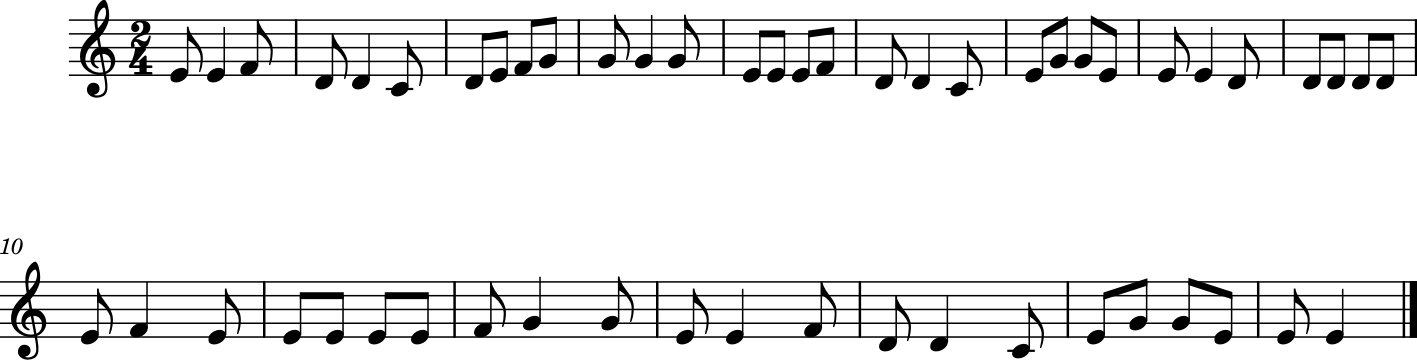

In [6]:
us=music21.environment.UserSettings()
us["musescoreDirectPNGPath"]="C:/Program Files/MuseScore 3/bin/MuseScore3.exe"
m.show()

## 코드 사전 정의

In [8]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([seq])
encoded= t.texts_to_sequences([seq])[0]
print(encoded)
print(t.word_index)

[2, 1, 5, 4, 3, 6, 7, 3, 1, 4, 2, 2, 8, 2, 1, 1, 1, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5, 3, 3, 3, 3, 3, 1, 9, 1, 1, 1, 1, 1, 4, 8, 2, 1, 5, 4, 3, 6, 7, 1, 2, 2, 1, 1, 5]
{'e8': 1, 'g8': 2, 'd8': 3, 'f8': 4, 'e4': 5, 'd4': 6, 'c8': 7, 'g4': 8, 'f4': 9}


In [10]:
# 사용은 이걸로
code2idx = {'c4': 0, 'd4': 1, 'e4': 2, 'f4': 3, 'g4': 4, 'a4': 5, 'b4': 6,
            'c8': 7, 'd8': 8, 'e8': 9, 'f8': 10, 'g8': 11, 'a8': 12, 'b8': 13}

idx2code = {0: 'c4', 1: 'd4', 2: 'e4', 3: 'f4', 4: 'g4', 5: 'a4', 6: 'b4',
            7: 'c8', 8: 'd8', 9: 'e8', 10: 'f8', 11: 'g8', 12: 'a8', 13: 'b8'}

# 2. 데이터 셋 생성하기

In [13]:
[code2idx[item] for item in seq]

[11,
 9,
 2,
 10,
 8,
 1,
 7,
 8,
 9,
 10,
 11,
 11,
 4,
 11,
 9,
 9,
 9,
 10,
 8,
 1,
 7,
 9,
 11,
 11,
 9,
 9,
 2,
 8,
 8,
 8,
 8,
 8,
 9,
 3,
 9,
 9,
 9,
 9,
 9,
 10,
 4,
 11,
 9,
 2,
 10,
 8,
 1,
 7,
 9,
 11,
 11,
 9,
 9,
 2]

In [14]:
# seq를 학습시킬 데이터 셋으로 반환하는 함수
# seq = 음계가 담긴 list, window_size: 독립변수의 갯수
def seq2dataset(seq,window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        encoded = [code2idx[item] for item in subset]
        dataset.append(encoded)
    return np.array(dataset) # tensorflow로 학습 시킬것이기 때문

## 생성

In [17]:
n_steps = 4 # 4개씩 학습(독립변수 개수)
n_inputs = 1
dataset = seq2dataset(seq=seq, window_size=n_steps)
dataset

array([[11,  9,  2, 10,  8],
       [ 9,  2, 10,  8,  1],
       [ 2, 10,  8,  1,  7],
       [10,  8,  1,  7,  8],
       [ 8,  1,  7,  8,  9],
       [ 1,  7,  8,  9, 10],
       [ 7,  8,  9, 10, 11],
       [ 8,  9, 10, 11, 11],
       [ 9, 10, 11, 11,  4],
       [10, 11, 11,  4, 11],
       [11, 11,  4, 11,  9],
       [11,  4, 11,  9,  9],
       [ 4, 11,  9,  9,  9],
       [11,  9,  9,  9, 10],
       [ 9,  9,  9, 10,  8],
       [ 9,  9, 10,  8,  1],
       [ 9, 10,  8,  1,  7],
       [10,  8,  1,  7,  9],
       [ 8,  1,  7,  9, 11],
       [ 1,  7,  9, 11, 11],
       [ 7,  9, 11, 11,  9],
       [ 9, 11, 11,  9,  9],
       [11, 11,  9,  9,  2],
       [11,  9,  9,  2,  8],
       [ 9,  9,  2,  8,  8],
       [ 9,  2,  8,  8,  8],
       [ 2,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  9],
       [ 8,  8,  8,  9,  3],
       [ 8,  8,  9,  3,  9],
       [ 8,  9,  3,  9,  9],
       [ 9,  3,  9,  9,  9],
       [ 3,  9,  9,  9,  9],
       [ 9,  9

## 독립변수(X),종속변수(Y)로 분리

In [18]:
x_train = dataset[:,:-1]
y_train = dataset[:,-1]

In [20]:
## 정규화 시킬 때 나눌 값 : code2idx의 제일 큰 value 값
max_idx_value=max(code2idx.values())

## 독립변수 정규화

In [23]:
print('정규화 전 x_train[:2] : ',x_train[:2],sep='\n')

정규화 전 x_train[:2] : 
[[11  9  2 10]
 [ 9  2 10  8]]


In [24]:
x_train = x_train /float(max_idx_value)
print('정규화 후 x_train[:2] :',x_train[:2],sep='\n')

정규화 후 x_train[:2] :
[[0.84615385 0.69230769 0.15384615 0.76923077]
 [0.69230769 0.15384615 0.76923077 0.61538462]]


## 독립변수의 shape 변환(샘플수,nsteps => 샘플수,nsteps,1)

In [25]:
x_train.shape

(50, 4)

In [26]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_train.shape

(50, 4, 1)

## 종속변수(라벨값)의 원핫인코딩

In [28]:
y_train = utils.to_categorical(y_train)

In [29]:
one_hot_vec_size = y_train.shape[1]

# 3. 모델 구성하기

In [30]:
model = Sequential()
model.add(LSTM(
    units=128,
    kernel_initializer='glorot_normal',
    bias_initializer='zero',
    batch_input_shape=(1, n_steps, n_inputs), 
    stateful=True
))
model.add(Dense(
    units=one_hot_vec_size, 
    kernel_initializer='glorot_normal',
    bias_initializer='zero',    
    activation='softmax'
))

# 4. 모델학습과정 설정하기

In [31]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 5. 모델 학습시키기

## loss,accuracy 클래스 정의

In [33]:
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.accuracy = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        if self.epoch % 100 == 0:
            print("epoch: {0} - loss: {1:8.6f} - accuracy: {1:8.6f}".format(self.epoch, logs.get('loss'),logs.get('accuracy')))
            
        self.epoch += 1

## 학습

In [34]:
num_epochs = 1500
history = LossHistory()  #객체 생성

for epoch_idx in range(num_epochs + 1):
    model.fit(
        x=x_train,
        y=y_train,
        epochs=1,
        batch_size=1,
        verbose=0,
        shuffle=False,
        callbacks=[history]
    )
    if history.losses[-1] < 1e-5:
        print("epoch: {0} - loss: {1:8.6f}".format(epoch_idx, history.losses[-1]))
        model.reset_states()    
        break
    model.reset_states()

epoch: 0 - loss: 2.396191 - accuracy: 2.396191
epoch: 100 - loss: 1.217244 - accuracy: 1.217244
epoch: 200 - loss: 0.012628 - accuracy: 0.012628
epoch: 300 - loss: 0.001127 - accuracy: 0.001127
epoch: 400 - loss: 0.000063 - accuracy: 0.000063
epoch: 469 - loss: 0.000010


# 6. 학습과정 살펴보기

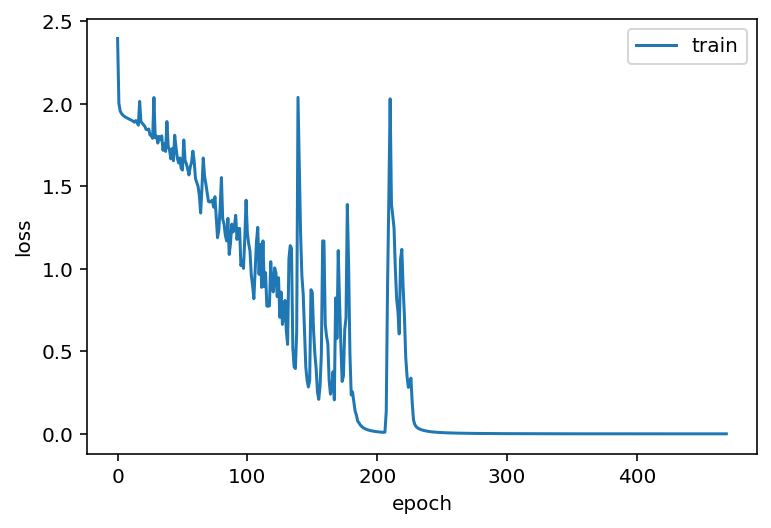

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# 7. 모델 평가

In [36]:
model.evaluate(x_train,y_train,batch_size=1)
model.reset_states()

50/50 [==============================] - 1s 847us/step - loss: 1.0316e-05 - accuracy: 1.0000


# 8. 모델 사용하기

In [38]:
# 한 단계 예측
temp = x_train[0].reshape(1,4,1)
temp

array([[[0.84615385],
        [0.69230769],
        [0.15384615],
        [0.76923077]]])

In [39]:
idx = np.argmax(model.predict(temp))
idx2code[idx]

'd8'

In [40]:
# 곡 전체 예측
pred_count = 50 # 최대 예측 개수
seq_in = ['g8', 'c8', 'f4', 'e8']
seq_out = seq_in
seq_in = [code2idx[note] / float(max_idx_value) for note in seq_in]  # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, n_steps, n_inputs))  # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()

print("full song prediction : ")

for note in seq_out:
    print(note, end=" ")

full song prediction : 
g8 c8 f4 e8 d4 d4 d8 e8 e8 f8 g8 g4 g8 e8 e8 e8 f8 f8 g4 g8 e8 e8 f8 f8 g4 g8 e8 e4 f8 d8 d4 c8 e8 g8 g8 e8 e8 e4 d8 d8 d8 d8 d8 e8 f4 e8 e8 e8 e8 f8 g4 d4 e8 e8 

In [41]:
note_seq = ""
for note in seq_out:
    note_seq += note + " "
    
conv_midi = music21.converter.subConverters.ConverterMidi()

m = music21.converter.parse("2/4 " + note_seq, format='tinyNotation')

m.show("midi")